<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/HAFSA_Atmosphere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Retrieves HAFS-A data from AWS along a storm's track using files generated by getStormTrack.ipynb.

Set up environment

In [ ]:
!pip install cfgrib
!pip install cartopy
!pip install tropycal

In [ ]:
from tropycal import tracks, rain
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import cfgrib
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cft

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

User parameters

In [ ]:
name = "Milton"
tcNum = "14"
filepath = f"/content/drive/MyDrive/savedData/{name}"
trackType = ""

Open TC Data

In [ ]:
tc = pd.read_csv(filepath + "/hurdat2_" + name + trackType + ".csv")

In [ ]:
tc

Retrieve HAFS-A Atmospheric Data

In [ ]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

start = tc.time[0]
startDate, startTime = start.split(" ")
startYear, startMonth, startDay = startDate.split("-")
startHour, startMinute, startSecond = startTime.split(":")

end = tc.time[len(tc)-1]
endDT = dt.strptime(end, dateFormat)
endDate, endTime = end.split(" ")
endYear, endMonth, endDay = endDate.split("-")
endHour, endMinute, endSecond = endTime.split(":")

Determine times needed

In [ ]:
bucket = "https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/"

fcastTimes = {} #Key: initiation, item: Forecast Hour

for row in tc.iloc:
  fcastTimes[row.time] = []
  rowTime = dt.strptime(row.time, dateFormat)
  if rowTime.hour % 6 != 0 or rowTime.minute != 0: continue #Skip any lines that don't have a HAFS forecast at the same time

  for fhour in range(0, 127, 3):
    valid = rowTime + pd.Timedelta(hours=fhour)
    if valid <= endDT:
      fcastTimes[row.time].append(fhour)

Get MSLP data from ATCF files.
(Format described [here](https://science.nrlmry.navy.mil/atcf/docs/database/new/abdeck.txt))

In [ ]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]
#"USERDEFINED3", "userdata3", "USERDEFINED4", "userdata4", "USERDEFINED5", "userdata5",
#Sample ATCF URL: https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241007/12/14l.2024100712.hfsa.trak.atcfunix

In [ ]:
stormFiles = []
stormMSLP = {} #Stores pressure along TC track for all forecast hours
stormVmax=  {}
stormLat = {}
stormLon = {}

for init, fhourList in fcastTimes.items():

  initDate, initTime = init.split(" ")
  initYear, initMonth, initDay = initDate.split("-")
  initHour, initMinute, initSecond = initTime.split(":")

  dateStr = initDate.replace("-", "")
  runStr = dateStr + initHour

  stormURL = bucket + dateStr + "/" + initHour + "/" + tcNum + "l." + dateStr + initHour + ".hfsa.trak.atcfunix"
  stormFile = "atcf_" + dateStr + "_" + initHour + ".csv"
  stormFiles.append(stormFile)

  !wget -O {stormFile} {stormURL}
  stormData = pd.read_csv(stormFile, names=cols)
  if len(stormData)==0: continue #ATCF file doesn't exist

  #for row in stormData.iloc:
  for fHour in fhourList:

    valid = stormData[stormData.TAU == fHour].iloc[0] #Files have duplicate forecast hours
    validDT = dt.strptime(runStr, runFormat) + pd.Timedelta(hours=fHour)

    if runStr not in stormMSLP.keys(): stormMSLP[runStr] = {}
    stormMSLP[runStr][validDT] = valid.MSLP
    if runStr not in stormVmax.keys(): stormVmax[runStr] = {}
    stormVmax[runStr][validDT] = valid.VMAX
    if runStr not in stormLat.keys(): stormLat[runStr] = {}
    stormLat[runStr][validDT] = float(valid["LatN/S"][0:4])/10 #Lat and lon are in tenths of a degree
    if runStr not in stormLon.keys(): stormLon[runStr] = {}
    stormLon[runStr][validDT] = float(valid["LonE/W"][0:5])/-10 #Lat and lon are in tenths of a degree. Western hemisphere assumed.

Create MSLP Figure

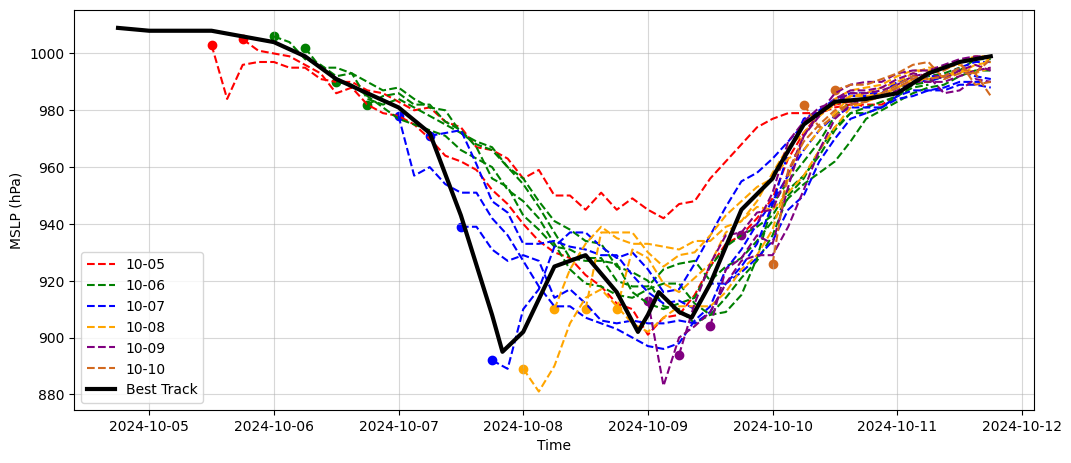

In [39]:
btDates = [dt.strptime(datetime, dateFormat) for datetime in tc.time]
runDates = [dt.strptime(run, runFormat) for run in stormMSLP.keys()]
stormStartMSLPs = [list(stormMSLP[key].values())[0] for key in stormMSLP.keys()]

cols = {5:"red", 6:"green", 7:"blue", 8:"orange", 9:"purple", 10:"chocolate"}
doneDays = []

mslpFig = plt.figure(figsize=(12, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

for run in stormMSLP.keys():
  mslpPlot = mslpAx.plot(stormMSLP[run].keys(), stormMSLP[run].values(), linestyle="--", color=cols[int(run[6:8])])
  if run[6:8] not in doneDays: mslpPlot[0].set_label(f"10-{run[6:8]}")
  doneDays.append(run[6:8])
  mslpAx.scatter(list(stormMSLP[run].keys())[0], list(stormMSLP[run].values())[0], color=cols[int(run[6:8])])

mslpAx.plot(btDates, tc.mslp, label="Best Track", color="black", linewidth=3)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("MSLP (hPa)")
mslpAx.grid(alpha=0.5)
mslpAx.legend()

mslpFig.savefig(filepath + "/mslp_allRuns.png")

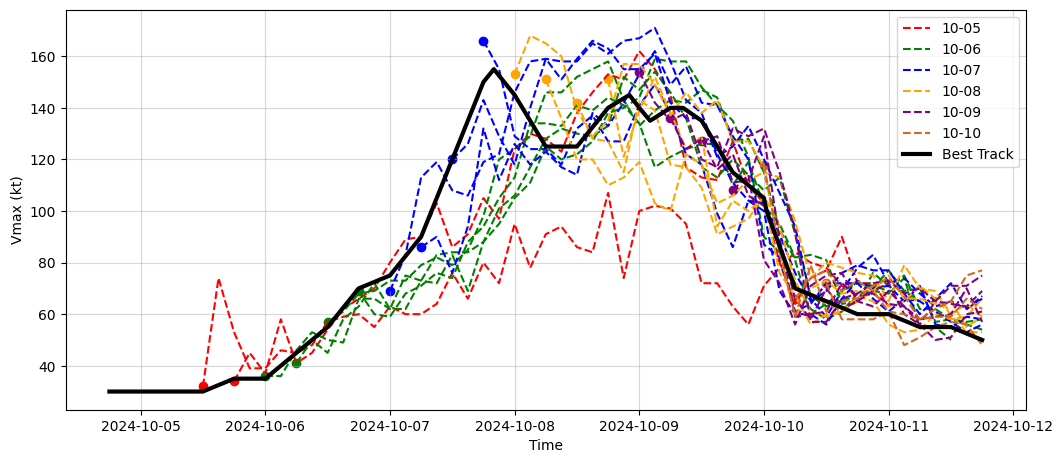

In [37]:
stormStartVmaxs = [list(stormVmax[key].values())[0] for key in stormVmax.keys()]

cols = {5:"red", 6:"green", 7:"blue", 8:"orange", 9:"purple", 10:"chocolate"}
doneDays = []

mslpFig = plt.figure(figsize=(12, 5))
mslpAx = mslpFig.add_axes([0.1,0.1,0.8,0.8])

for run in stormVmax.keys():
  mslpPlot = mslpAx.plot(stormVmax[run].keys(), stormVmax[run].values(), linestyle="--", color=cols[int(run[6:8])])
  if run[6:8] not in doneDays: mslpPlot[0].set_label(f"10-{run[6:8]}")
  doneDays.append(run[6:8])
  mslpAx.scatter(list(stormVmax[run].keys())[0], list(stormVmax[run].values())[0], color=cols[int(run[6:8])])

mslpAx.plot(btDates, tc.vmax, label="Best Track", color="black", linewidth=3)

mslpAx.set_xlabel("Time")
mslpAx.set_ylabel("Vmax (kt)")
mslpAx.grid(alpha=0.5)
mslpAx.legend()

mslpFig.savefig(filepath + "/vmax_allRuns.png")

Plot model tracks

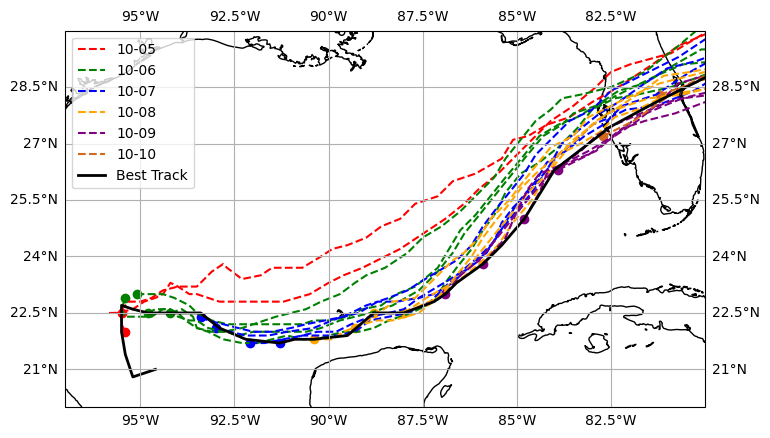

In [38]:
trackFig = plt.figure(figsize=(8, 5))
trackAx = trackFig.add_axes([0.1,0.1,0.8,0.8], projection=ccrs.PlateCarree())

cols = {5:"red", 6:"green", 7:"blue", 8:"orange", 9:"purple", 10:"chocolate"}
doneDays = []

for run in stormLat.keys():
  trackPlot = trackAx.plot(stormLon[run].values(), stormLat[run].values(), linestyle="--", color=cols[int(run[6:8])])
  if run[6:8] not in doneDays: trackPlot[0].set_label(f"10-{run[6:8]}")
  doneDays.append(run[6:8])
  trackAx.scatter(list(stormLon[run].values())[0], list(stormLat[run].values())[0], color=cols[int(run[6:8])])

trackAx.plot(tc.lon, tc.lat, color="black", linewidth=2, label="Best Track")

trackAx.legend()
trackAx.set_extent([-97, -80, 20, 30])
trackAx.add_feature(cft.COASTLINE)
trackAx.add_feature(cft.BORDERS)
trackAx.gridlines(draw_labels=True)